In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

import itertools

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEClassification, KDEOutliersDetection, KDEClustering
from kdelearn.ckde import CKDE
from kdelearn.ckde_tasks import CKDEClassification, CKDEOutliersDetection, CKDEClustering
from kdelearn.bandwidth_selection import direct_plugin

# Dane

Parametry mieszaniny rozkładów Gaussa używanych w dalszych przykładach:

$$
seed=1
$$

$$
m=1000
$$

$$
m_1=0.25m
$$

\begin{equation*}
E_1 =
\left(\begin{array}{c}
-3 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_1 =
\left(\begin{array}{cc}\ 
4 & -1.4\\
-1.4 & 1
\end{array}\right)
\end{equation*}


$$
m_2=0.5m
$$

\begin{equation*}
E_2 =
\left(\begin{array}{c}
2 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_2 =
\left(\begin{array}{cc}\ 
1 & 0.7\\
0.7 & 1
\end{array}\right)
\end{equation*}


$$
m_3=0.15m
$$

\begin{equation*}
E_3 =
\left(\begin{array}{c}
5 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_3 =
\left(\begin{array}{cc}\ 
1 & 0.9\\
0.9 & 1
\end{array}\right)
\end{equation*}


$$
m_4=0.1m
$$

\begin{equation*}
E_4 =
\left(\begin{array}{c}
0 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_4 =
\left(\begin{array}{cc}\ 
16 & 0\\
0 & 4
\end{array}\right)
\end{equation*}

Uwaga: Dane z 4 członu to traktowane są jako szum

## Treningowe

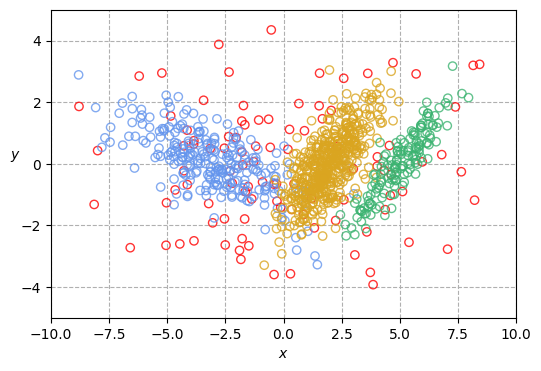

In [3]:
np.random.seed(1)

# Data
n_experiments = 100
m_train = 1000
n_x, n_y = 1, 1

# Class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
# Class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
# Class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
# Class 4
m_train4 = int(0.1 * m_train)
mean4 = [0, 0]
cov4 = [[16, 0],
        [0, 4]]

z_train = np.empty((n_experiments, m_train, n_x + n_y))
labels_train1 = np.full(m_train1, 1, dtype=np.int32)
labels_train2 = np.full(m_train2, 2, dtype=np.int32)
labels_train3 = np.full(m_train3, 3, dtype=np.int32)
labels_train4 = np.full(m_train4, 4, dtype=np.int32)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))

for e in range(n_experiments):
    # Class 1
    z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
    # Class 2
    z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
    # Class 3
    z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
    # Class 4
    z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)

    z_train[e, :, :] = np.concatenate((z_train1, z_train2, z_train3, z_train4), axis=0)

x_train = z_train[:, :, [0]]
y_train = z_train[:, :, [1]]


# Plot
plt.figure(figsize=(6, 4))

plt.scatter(x_train[0, -m_train4:], y_train[0, -m_train4:], facecolors="none", edgecolors="red", zorder=2, alpha=0.8)
plt.scatter(x_train[0, :m_train1], y_train[0, :m_train1], facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train[0, m_train1:m_train1+m_train2], y_train[0, m_train1:m_train1+m_train2], facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], y_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.grid(linestyle="--")
plt.show()

## Testowe

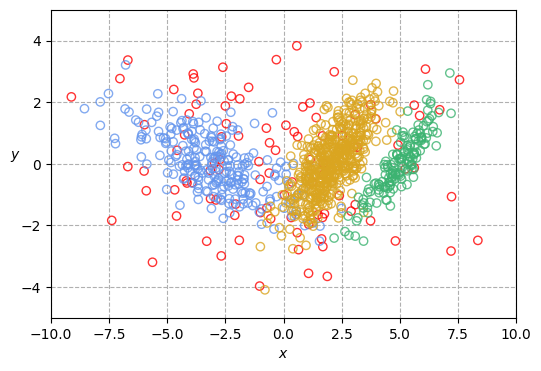

In [4]:
np.random.seed(147)

# Data
m_test = 1000

# Class 1
m_test1 = int(0.25 * m_test)
# Class 2
m_test2 = int(0.5 * m_test)
# Class 3
m_test3 = int(0.15 * m_test)
# Class 4
m_test4 = int(0.1 * m_test)

z_test = np.empty((n_experiments, m_test, n_x + n_y))
labels_test1 = np.full(m_test1, 1, dtype=np.int32)
labels_test2 = np.full(m_test2, 2, dtype=np.int32)
labels_test3 = np.full(m_test3, 3, dtype=np.int32)
labels_test4 = np.full(m_test4, 4, dtype=np.int32)
labels_test = np.concatenate((labels_test1, labels_test2, labels_test3, labels_test4))

for e in range(n_experiments):
    # Class 1
    z_test1 = np.random.multivariate_normal(mean1, cov1, m_test1)
    # Class 2
    z_test2 = np.random.multivariate_normal(mean2, cov2, m_test2)
    # Class 3
    z_test3 = np.random.multivariate_normal(mean3, cov3, m_test3)
    # Class 4
    z_test4 = np.random.multivariate_normal(mean4, cov4, m_test4)

    z_test[e, :, :] = np.concatenate((z_test1, z_test2, z_test3, z_test4), axis=0)

x_test = z_test[:, :, [0]]
y_test = z_test[:, :, [1]]


# Plot
plt.figure(figsize=(6, 4))

plt.scatter(x_test[0, -m_test4:], y_test[0, -m_test4:], facecolors="none", edgecolors="red", zorder=2, alpha=0.8)
plt.scatter(x_test[0, :m_test1], y_test[0, :m_test1], facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_test[0, m_test1:m_test1+m_test2], y_test[0, m_test1:m_test1+m_test2], facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_test[0, m_test1+m_test2:m_test1+m_test2+m_test3], y_test[0, m_test1+m_test2:m_test1+m_test2+m_test3], facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.grid(linestyle="--")
plt.show()

In [5]:
# Utworzone zbiory

print(z_train.shape, labels_train.shape)
print(z_test.shape, labels_test.shape)

(100, 1000, 2) (1000,)
(100, 1000, 2) (1000,)


\newpage

# Klasyfikacja

- Stosowana jest metoda podstawień do estymacji rozkładów klas
- Szum (czwarty czynnik) nie jest tutaj brany pod uwagę

## Dane

In [9]:
z_train = z_train[:, :-m_train4, :]
x_train = x_train[:, :-m_train4, :]
y_train = y_train[:, :-m_train4, :]
labels_train = labels_train[:-m_train4]
m_train = z_train.shape[1]

z_test = z_test[:, :-m_test4, :]
x_test = x_test[:, :-m_test4, :]
y_test = y_test[:, :-m_test4, :]
labels_test = labels_test[:-m_test4]
m_test = z_test.shape[1]

ulabels = np.unique(labels_train)  # Sorted unique labels
n_classes = ulabels.shape[0]
x_grid = np.linspace(-10, 10, 1000)[:, None]

### Treningowe

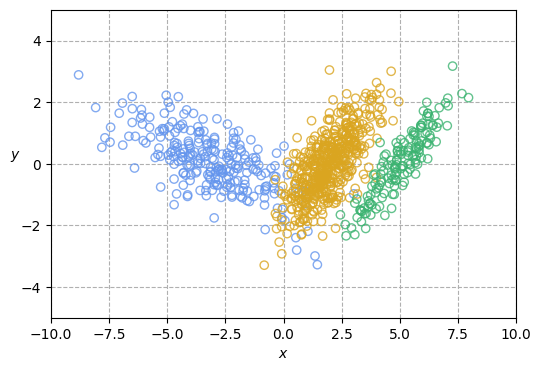

In [10]:
# Plot
plt.figure(figsize=(6, 4))

plt.scatter(x_train[0, :m_train1], y_train[0, :m_train1], facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train[0, m_train1:m_train1+m_train2], y_train[0, m_train1:m_train1+m_train2], facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], y_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.grid(linestyle="--")
plt.show()

### Testowe

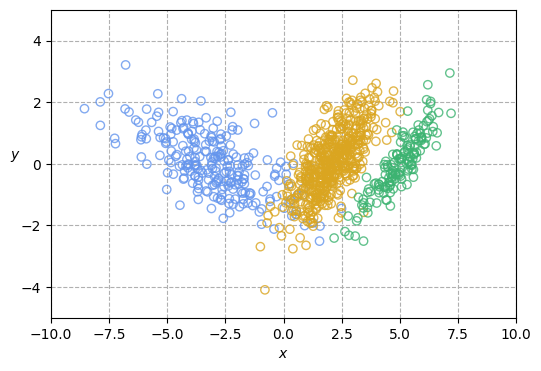

In [13]:
# Plot
plt.figure(figsize=(6, 4))

plt.scatter(x_test[0, :m_test1], y_test[0, :m_test1], facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_test[0, m_test1:m_test1+m_test2], y_test[0, m_test1:m_test1+m_test2], facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_test[0, m_test1+m_test2:m_test1+m_test2+m_test3], y_test[0, m_test1+m_test2:m_test1+m_test2+m_test3], facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.grid(linestyle="--")
plt.show()

\newpage

In [14]:
bandwidths_z = np.zeros((n_experiments, n_classes, n_x + n_y))
for e in range(n_experiments):
    for idx, label in enumerate(ulabels):
        mask = labels_train == label
        bandwidths_z[e, idx, :] = direct_plugin(z_train[e, mask])
bandwidths_x = bandwidths_z[:, :, :n_x]
bandwidths_y = bandwidths_z[:, :, n_x:]

## Ujęcie bezwarunkowe

Wykresy wyrysowane na bazie zbioru treningowego (jednego wybranego)

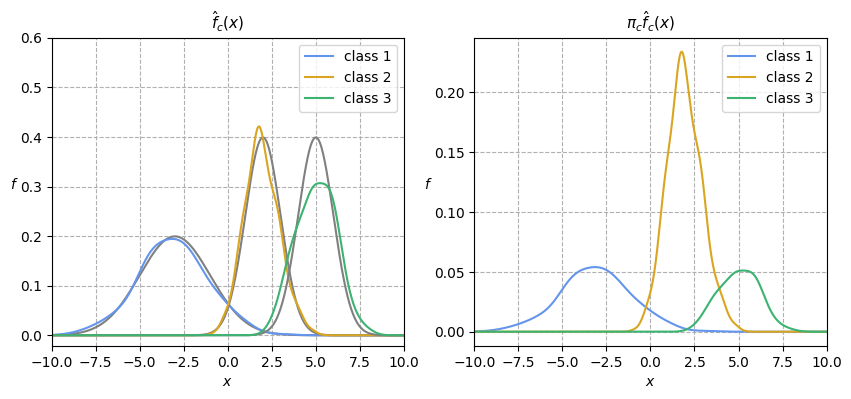

In [15]:
kde_classifier = KDEClassification().fit(x_train[0], labels_train, bandwidths=bandwidths_x[0])
scores_for_classes = kde_classifier.pdfs(x_grid)

scores1 = scores_for_classes[:, 0]
scores2 = scores_for_classes[:, 1]
scores3 = scores_for_classes[:, 2]


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

true_dist1 = norm.pdf(x_grid, loc=-3, scale=2)
axs[0].plot(x_grid, true_dist1, c="grey")
axs[0].plot(x_grid, scores1, c="cornflowerblue", label="class 1")
true_dist2 = norm.pdf(x_grid, loc=2, scale=1)
axs[0].plot(x_grid, true_dist2, c="grey")
axs[0].plot(x_grid, scores2, c="goldenrod", label="class 2")
true_dist3 = norm.pdf(x_grid, loc=5, scale=1)
axs[0].plot(x_grid, true_dist3, c="grey")
axs[0].plot(x_grid, scores3, c="mediumseagreen", label="class 3")
axs[0].set_title("$\hat{f}_c(x)$", fontsize=11)
axs[0].legend(fontsize=10)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$f$", rotation=0)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.6)
axs[0].grid(linestyle="--")

axs[1].plot(x_grid, m_train1 / m_train * scores1, c="cornflowerblue", label="class 1")
axs[1].plot(x_grid, m_train2 / m_train * scores2, c="goldenrod", label="class 2")
axs[1].plot(x_grid, m_train3 / m_train * scores3, c="mediumseagreen", label="class 3")
axs[1].set_title("$\\pi_c \\hat{f}_c(x)$", fontsize=11)
axs[1].legend(fontsize=10)
axs[1].set_xlim(-10, 10)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$f$", rotation=0)
axs[1].grid(linestyle="--")

plt.show()

\newpage

### Testowanie na zbiorze testowym

In [16]:
labels_pred = kde_classifier.predict(x_test[0])

accuracy = np.mean(labels_pred == labels_test)
print(f"Wskaźnik jakości (accuracy): {accuracy:.6f}")

Wskaźnik jakości (accuracy): 0.930000


#### Dopasowanie $h$ na siatce

In [17]:
fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
# fac_grid = [1.0, 0.75, 1.5, 0.5, 2.0]
# fac_grid = [1.0, 0.5, 2.0]

print(f"Mnożniki na siatce (wspólne dla wszystkich klas): {fac_grid}")

Mnożniki na siatce (wspólne dla wszystkich klas): [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]


In [18]:
accuracies = []
for x_fac in fac_grid:
    tmp_classifier = KDEClassification().fit(
        x_train[0],
        labels_train,
        bandwidths=bandwidths_x[0] * x_fac
    )
    tmp_labels_pred = tmp_classifier.predict(x_test[0])

    tmp_accuracy = np.mean(tmp_labels_pred == labels_test)
    accuracies.append(tmp_accuracy)

argmax = np.argmax(accuracies)
best_bandwidth_multiplier = fac_grid[argmax]

print(f"Najlepszy wskaźnik jakości (accuracy): {accuracies[argmax]:.6f}")
print(f"Dla mnożnika: {best_bandwidth_multiplier}")

Najlepszy wskaźnik jakości (accuracy): 0.932222
Dla mnożnika: 1.4


In [19]:
# fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
# fac_grid = [1.0, 0.75, 1.5, 0.5, 2.0]
fac_grid = [1.0, 0.5, 2.0]

tt = [p for p in itertools.product(fac_grid, repeat=3)]

print(f"Mnożniki na siatce (odrębne dla wszystkich klas): {fac_grid}")

Mnożniki na siatce (odrębne dla wszystkich klas): [1.0, 0.5, 2.0]


In [20]:
accuracies = []
for x_fac_c1, x_fac_c2, x_fac_c3 in tt:
    tmp_bandwidths = (bandwidths_x[0, :, 0] * np.array([x_fac_c1, x_fac_c2, x_fac_c3]))[:, None]
    tmp_classifier = KDEClassification().fit(
        x_train[0],
        labels_train,
        bandwidths=tmp_bandwidths
    )
    tmp_labels_pred = tmp_classifier.predict(x_test[0])

    tmp_accuracy = np.mean(tmp_labels_pred == labels_test)
    accuracies.append(tmp_accuracy)

argmax = np.argmax(accuracies)
best_bandwidth_multipliers = tt[argmax]

print(f"Najlepszy wskaźnik jakości (accuracy): {accuracies[argmax]:.6f}")
print(f"Dla mnożników: {best_bandwidth_multipliers}")

Najlepszy wskaźnik jakości (accuracy): 0.932222
Dla mnożników: (1.0, 1.0, 2.0)


### Testowanie wielokrotne

In [23]:
accuracies = np.empty((n_experiments,))
for e in range(n_experiments):
    tmp_kde_classifier = KDEClassification().fit(x_train[e], labels_train, bandwidths=bandwidths_x[e])
    tmp_labels_pred = tmp_kde_classifier.predict(x_test[e])
    accuracies[e] = np.mean(tmp_labels_pred == labels_test)

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (accuracy): {np.mean(accuracies):.6f} +- {np.std(accuracies):.6f}")

Wskaźnik jakości dla 100 eksperymentów (accuracy): 0.930067 +- 0.008802


#### Dopasowanie $h$ na siatce

In [24]:
fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
# fac_grid = [1.0, 0.75, 1.5, 0.5, 2.0]
# fac_grid = [1.0, 0.5, 2.0]

print(f"Mnożniki na siatce (wspólne dla wszystkich klas): {fac_grid}")

Mnożniki na siatce (wspólne dla wszystkich klas): [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]


In [25]:
best_accuracies = np.empty((n_experiments,))

for e in range(n_experiments):

    accuracies = []
    for x_fac in fac_grid:
        tmp_classifier = KDEClassification().fit(
            x_train[e],
            labels_train,
            bandwidths=bandwidths_x[e] * x_fac
        )
        tmp_labels_pred = tmp_classifier.predict(x_test[e])

        tmp_accuracy = np.mean(tmp_labels_pred == labels_test)
        accuracies.append(tmp_accuracy)
    argmax = np.argmax(accuracies)
    best_accuracies[e] = accuracies[argmax]

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (accuracy): {np.mean(best_accuracies):.6f} +- {np.std(best_accuracies):.6f}")

Wskaźnik jakości dla 100 eksperymentów (accuracy): 0.932156 +- 0.008331


In [26]:
# fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
# fac_grid = [1.0, 0.75, 1.5, 0.5, 2.0]
fac_grid = [1.0, 0.5, 2.0]

tt = [p for p in itertools.product(fac_grid, repeat=3)]

print(f"Mnożniki na siatce (odrębne dla wszystkich klas): {fac_grid}")

Mnożniki na siatce (odrębne dla wszystkich klas): [1.0, 0.5, 2.0]


In [27]:
best_accuracies = np.empty((n_experiments,))

for e in range(n_experiments):

    accuracies = []
    for x_fac_c1, x_fac_c2, x_fac_c3 in tt:
        tmp_bandwidths = (bandwidths_x[e, :, 0] * np.array([x_fac_c1, x_fac_c2, x_fac_c3]))[:, None]
        tmp_classifier = KDEClassification().fit(
            x_train[e],
            labels_train,
            bandwidths=tmp_bandwidths
        )
        tmp_labels_pred = tmp_classifier.predict(x_test[e])

        tmp_accuracy = np.mean(tmp_labels_pred == labels_test)
        accuracies.append(tmp_accuracy)
    argmax = np.argmax(accuracies)
    best_accuracies[e] = accuracies[argmax]

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (accuracy): {np.mean(best_accuracies):.6f} +- {np.std(best_accuracies):.6f}")

Wskaźnik jakości dla 100 eksperymentów (accuracy): 0.932544 +- 0.008184


\newpage

## Ujęcie warunkowe

### Testowanie na zbiorze testowym przy $y^*=y_i$

In [29]:
labels_pred = np.empty(m_test, dtype=np.int32)
for i in range(m_test):
    tmp_classifier = CKDEClassification().fit(
        x_train[0],
        y_train[0],
        y_test[0, i],
        labels_train,
        bandwidths_x=bandwidths_x[0],
        bandwidths_y=bandwidths_y[0]
    )
    labels_pred[i] = tmp_classifier.predict(x_test[0, [i]])

accuracy = np.mean(labels_train == labels_pred)
print(f"Wskaźnik jakości (accuracy): {accuracy:.6f}")

Wskaźnik jakości (accuracy): 0.967778


#### Dopasowanie $h$ na siatce

In [30]:
fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
# fac_grid = [1.0, 0.75, 1.5, 0.5, 2.0]
# fac_grid = [1.0, 0.5, 2.0]

tt = [p for p in itertools.product(fac_grid, repeat=2)]

print(f"Mnożniki na siatce [x] (wspólne dla wszystkich klas): {fac_grid}")
print(f"Mnożniki na siatce [y] (wspólne dla wszystkich klas): {fac_grid}")

Mnożniki na siatce [x] (wspólne dla wszystkich klas): [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
Mnożniki na siatce [y] (wspólne dla wszystkich klas): [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]


In [31]:
accuracies = []
for x_fac, y_fac in tt:

    tmp_labels_pred = np.empty(m_test, dtype=np.int32)
    for i in range(m_test):
        tmp_classifier = CKDEClassification().fit(x_train[0], y_train[0], y_test[0, i], labels_train,
                                                  bandwidths_x=bandwidths_x[0] * x_fac,
                                                  bandwidths_y=bandwidths_y[0] * y_fac)
        tmp_labels_pred[i] = tmp_classifier.predict(x_test[0, [i]])
    
    accuracy = np.mean(tmp_labels_pred == labels_test)
    accuracies.append(accuracy)

argmax = np.argmax(accuracies)
best_bandwidth_multipliers = tt[argmax]

print(f"Najlepszy wskaźnik jakości (accuracy): {accuracies[argmax]:.6f}")
print(f"Dla mnożników [x, y]: {best_bandwidth_multipliers}")

Najlepszy wskaźnik jakości (accuracy): 0.968889
Dla mnożników [x, y]: (1.6, 1.0)


In [32]:
# fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
# fac_grid = [1.0, 0.75, 1.5, 0.5, 2.0]
fac_grid = [1.0, 0.5, 2.0]

tt = [p for p in itertools.product(fac_grid, repeat=6)]

print(f"Mnożniki na siatce [x] (odrębne dla wszystkich klas): {fac_grid}")
print(f"Mnożniki na siatce [y] (odrębne dla wszystkich klas): {fac_grid}")

Mnożniki na siatce [x] (odrębne dla wszystkich klas): [1.0, 0.5, 2.0]
Mnożniki na siatce [y] (odrębne dla wszystkich klas): [1.0, 0.5, 2.0]


In [33]:
accuracies = []
for x_fac_c1, x_fac_c2, x_fac_c3, y_fac_c1, y_fac_c2, y_fac_c3 in tt:
    tmp_bandwidths_x = bandwidths_x[0] * np.array([[x_fac_c1], [x_fac_c2], [x_fac_c3]])
    tmp_bandwidths_y = bandwidths_y[0] * np.array([[y_fac_c1], [y_fac_c2], [y_fac_c3]])

    tmp_labels_pred = np.empty(m_test, dtype=np.int32)
    for i in range(m_test):
        tmp_classifier = CKDEClassification().fit(x_train[0], y_train[0], y_test[0, i], labels_train,
                                                  bandwidths_x=tmp_bandwidths_x,
                                                  bandwidths_y=tmp_bandwidths_y)
        tmp_labels_pred[i] = tmp_classifier.predict(x_test[0, [i]])
    
    accuracy = np.mean(tmp_labels_pred == labels_test)
    accuracies.append(accuracy)

argmax = np.argmax(accuracies)
best_bandwidth_multipliers = tt[argmax]

print(f"Najlepszy wskaźnik jakości (accuracy): {accuracies[argmax]:.6f}")
print(f"Dla mnożników [x]: {best_bandwidth_multipliers[:n_classes]}")
print(f"Dla mnożników [y]: {best_bandwidth_multipliers[n_classes:]}")

Najlepszy wskaźnik jakości (accuracy): 0.970000
Dla mnożników [x]: (2.0, 0.5, 1.0)
Dla mnożników [y]: (1.0, 1.0, 1.0)


### Testowanie wielokrotne

In [32]:
accuracies = np.empty((n_experiments,))
for e in range(n_experiments):
    tmp_labels_pred = np.empty(m_test, dtype=np.int32)
    for i in range(m_test):
        tmp_classifier = CKDEClassification().fit(
            x_train[e],
            y_train[e],
            y_test[e, i],
            labels_train,
            bandwidths_x=bandwidths_x[0],
            bandwidths_y=bandwidths_y[0]
        )
        tmp_labels_pred[i] = tmp_classifier.predict(x_test[e, [i]])
    accuracies[e] = np.mean(tmp_labels_pred == labels_test)

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (accuracy): {np.mean(accuracies):.6f} +- {np.std(accuracies):.6f}")

Wskaźnik jakości dla 100 eksperymentów (accuracy): 0.966078 +- 0.005972


#### Dopasowanie $h$ na siatce

In [27]:
fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
# fac_grid = [1.0, 0.75, 1.5, 0.5, 2.0]
# fac_grid = [1.0, 0.5, 2.0]

tt = [p for p in itertools.product(fac_grid, repeat=2)]

print(f"Mnożniki na siatce [x] (wspólne dla wszystkich klas): {fac_grid}")
print(f"Mnożniki na siatce [y] (wspólne dla wszystkich klas): {fac_grid}")

Mnożniki na siatce [x] (wspólne dla wszystkich klas): [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
Mnożniki na siatce [y] (wspólne dla wszystkich klas): [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]


In [28]:
best_accuracies = np.empty((n_experiments,))

for e in range(n_experiments):

    accuracies = []
    for x_fac, y_fac in tt:
        tmp_labels_pred = np.empty(m_test, dtype=np.int32)
        for i in range(m_test):
            tmp_classifier = CKDEClassification().fit(x_train[e], y_train[e], y_test[e, i], labels_train,
                                                      bandwidths_x=bandwidths_x[e] * x_fac,
                                                      bandwidths_y=bandwidths_y[e] * y_fac)
            tmp_labels_pred[i] = tmp_classifier.predict(x_test[e, [i]])

        tmp_accuracy = np.mean(tmp_labels_pred == labels_test)
        accuracies.append(tmp_accuracy)
    argmax = np.argmax(accuracies)
    best_accuracies[e] = accuracies[argmax]

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (accuracy): {np.mean(best_accuracies):.6f} +- {np.std(best_accuracies):.6f}")

Wskaźnik jakości dla 100 eksperymentów (accuracy): 0.969333 +- 0.005560


In [35]:
# fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]
# fac_grid = [1.0, 0.75, 1.5, 0.5, 2.0]
fac_grid = [1.0, 0.5, 2.0]

tt = [p for p in itertools.product(fac_grid, repeat=6)]

print(f"Mnożniki na siatce [x] (odrębne dla wszystkich klas): {fac_grid}")
print(f"Mnożniki na siatce [y] (odrębne dla wszystkich klas): {fac_grid}")

Mnożniki na siatce [x] (odrębne dla wszystkich klas): [1.0, 0.5, 2.0]
Mnożniki na siatce [y] (odrębne dla wszystkich klas): [1.0, 0.5, 2.0]


In [36]:
best_accuracies = np.empty((n_experiments,))

for e in range(n_experiments):

    accuracies = []
    for x_fac_c1, x_fac_c2, x_fac_c3, y_fac_c1, y_fac_c2, y_fac_c3 in tt:
        tmp_bandwidths_x = bandwidths_x[e] * np.array([[x_fac_c1], [x_fac_c2], [x_fac_c3]])
        tmp_bandwidths_y = bandwidths_y[e] * np.array([[y_fac_c1], [y_fac_c2], [y_fac_c3]])

        tmp_labels_pred = np.empty(m_test, dtype=np.int32)
        for i in range(m_test):
            tmp_classifier = CKDEClassification().fit(x_train[e], y_train[e], y_test[e, i], labels_train,
                                                      bandwidths_x=tmp_bandwidths_x,
                                                      bandwidths_y=tmp_bandwidths_y)
            tmp_labels_pred[i] = tmp_classifier.predict(x_test[e, [i]])

        tmp_accuracy = np.mean(tmp_labels_pred == labels_test)
        accuracies.append(tmp_accuracy)
    argmax = np.argmax(accuracies)
    best_accuracies[e] = accuracies[argmax]

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (accuracy): {np.mean(best_accuracies):.6f} +- {np.std(best_accuracies):.6f}")

Wskaźnik jakości dla 100 eksperymentów (accuracy): 0.970811 +- 0.005564


\newpage

### Testowanie w otoczeniu $y^*$

- W paśmie $y^* - 0.1y_{std} < y_i < y^* + 0.1y_{std} $

In [31]:
# Dane testowe w otoczeniu y_star=-2

np.random.seed(0)

y_star_neg = np.array([-2.0] * n_y)
y_train_std = 0.1 * np.std(y_train)

## 1
x_test1_neg = np.empty((m_test1, n_x))
y_test1_neg = np.empty((m_test1, n_y))
labels_test1_neg = np.full(m_test1, 1, dtype=np.int64)
l = 0
while l < m_test1:
    z_test1_neg = np.random.multivariate_normal(mean1, cov1, 1)
    if y_star_neg[0] - y_train_std < z_test1_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test1_neg[l] = z_test1_neg[:, [0]]
        y_test1_neg[l] = z_test1_neg[:, [1]]
        l += 1

## 2
x_test2_neg = np.empty((m_test2, n_x))
y_test2_neg = np.empty((m_test2, n_y))
labels_test2_neg = np.full(m_test2, 2, dtype=np.int64)
l = 0
while l < m_test2:
    z_test2_neg = np.random.multivariate_normal(mean2, cov2, 1)
    if y_star_neg[0] - y_train_std < z_test2_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test2_neg[l] = z_test2_neg[:, [0]]
        y_test2_neg[l] = z_test2_neg[:, [1]]
        l += 1

## 3
x_test3_neg = np.empty((m_test3, n_x))
y_test3_neg = np.empty((m_test3, n_y))
labels_test3_neg = np.full(m_test3, 3, dtype=np.int64)
l = 0
while l < m_test3:
    z_test3_neg = np.random.multivariate_normal(mean3, cov3, 1)
    if y_star_neg[0] - y_train_std < z_test3_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test3_neg[l] = z_test3_neg[:, [0]]
        y_test3_neg[l] = z_test3_neg[:, [1]]
        l += 1

## 4
x_test4_neg = np.empty((m_test4, n_x))
y_test4_neg = np.empty((m_test4, n_y))
labels_test4_neg = np.full(m_test4, 3, dtype=np.int64)
l = 0
while l < m_test4:
    z_test4_neg = np.random.multivariate_normal(mean4, cov4, 1)
    if y_star_neg[0] - y_train_std < z_test4_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test4_neg[l] = z_test4_neg[:, [0]]
        y_test4_neg[l] = z_test4_neg[:, [1]]
        l += 1
## 
x_test_neg = np.concatenate((x_test1_neg, x_test2_neg, x_test3_neg, x_test4_neg), axis=0)
y_test_neg = np.concatenate((y_test1_neg, y_test2_neg, y_test3_neg, y_test4_neg), axis=0)
labels_test_neg = np.concatenate((labels_test1_neg, labels_test2_neg, labels_test3_neg, labels_test4_neg))

In [32]:
# Dane testowe w otoczeniu y_star=0

np.random.seed(0)

y_star_neu = np.array([0.0] * n_y)
y_train_std = 0.1 * np.std(y_train)

## 1
x_test1_neu = np.empty((m_test1, n_x))
y_test1_neu = np.empty((m_test1, n_y))
labels_test1_neu = np.full(m_test1, 1, dtype=np.int64)
l = 0
while l < m_test1:
    z_test1_neu = np.random.multivariate_normal(mean1, cov1, 1)
    if y_star_neu[0] - y_train_std < z_test1_neu[0, 1] < y_star_neu[0] + y_train_std: 
        x_test1_neu[l] = z_test1_neu[:, [0]]
        y_test1_neu[l] = z_test1_neu[:, [1]]
        l += 1

## 2
x_test2_neu = np.empty((m_test2, n_x))
y_test2_neu = np.empty((m_test2, n_y))
labels_test2_neu = np.full(m_test2, 2, dtype=np.int64)
l = 0
while l < m_test2:
    z_test2_neu = np.random.multivariate_normal(mean2, cov2, 1)
    if y_star_neu[0] - y_train_std < z_test2_neu[0, 1] < y_star_neu[0] + y_train_std: 
        x_test2_neu[l] = z_test2_neu[:, [0]]
        y_test2_neu[l] = z_test2_neu[:, [1]]
        l += 1

## 3
x_test3_neu = np.empty((m_test3, n_x))
y_test3_neu = np.empty((m_test3, n_y))
labels_test3_neu = np.full(m_test3, 3, dtype=np.int64)
l = 0
while l < m_test3:
    z_test3_neu = np.random.multivariate_normal(mean3, cov3, 1)
    if y_star_neu[0] - y_train_std < z_test3_neu[0, 1] < y_star_neu[0] + y_train_std: 
        x_test3_neu[l] = z_test3_neu[:, [0]]
        y_test3_neu[l] = z_test3_neu[:, [1]]
        l += 1

## 4
x_test4_neu = np.empty((m_test4, n_x))
y_test4_neu = np.empty((m_test4, n_y))
labels_test4_neu = np.full(m_test4, 3, dtype=np.int64)
l = 0
while l < m_test4:
    z_test4_neu = np.random.multivariate_normal(mean4, cov4, 1)
    if y_star_neu[0] - y_train_std < z_test4_neu[0, 1] < y_star_neu[0] + y_train_std: 
        x_test4_neu[l] = z_test4_neu[:, [0]]
        y_test4_neu[l] = z_test4_neu[:, [1]]
        l += 1
## 
x_test_neu = np.concatenate((x_test1_neu, x_test2_neu, x_test3_neu, x_test4_neu), axis=0)
y_test_neu = np.concatenate((y_test1_neu, y_test2_neu, y_test3_neu, y_test4_neu), axis=0)
labels_test_neu = np.concatenate((labels_test1_neu, labels_test2_neu, labels_test3_neu, labels_test4_neu))

In [33]:
# Dane testowe w otoczeniu y_star=2

np.random.seed(0)

y_star_pos = np.array([2.0] * n_y)
y_train_std = 0.1 * np.std(y_train)

## 1
x_test1_pos = np.empty((m_test1, n_x))
y_test1_pos = np.empty((m_test1, n_y))
labels_test1_pos = np.full(m_test1, 1, dtype=np.int64)
l = 0
while l < m_test1:
    z_test1_pos = np.random.multivariate_normal(mean1, cov1, 1)
    if y_star_pos[0] - y_train_std < z_test1_pos[0, 1] < y_star_pos[0] + y_train_std: 
        x_test1_pos[l] = z_test1_pos[:, [0]]
        y_test1_pos[l] = z_test1_pos[:, [1]]
        l += 1

## 2
x_test2_pos = np.empty((m_test2, n_x))
y_test2_pos = np.empty((m_test2, n_y))
labels_test2_pos = np.full(m_test2, 2, dtype=np.int64)
l = 0
while l < m_test2:
    z_test2_pos = np.random.multivariate_normal(mean2, cov2, 1)
    if y_star_pos[0] - y_train_std < z_test2_pos[0, 1] < y_star_pos[0] + y_train_std: 
        x_test2_pos[l] = z_test2_pos[:, [0]]
        y_test2_pos[l] = z_test2_pos[:, [1]]
        l += 1

## 3
x_test3_pos = np.empty((m_test3, n_x))
y_test3_pos = np.empty((m_test3, n_y))
labels_test3_pos = np.full(m_test3, 3, dtype=np.int64)
l = 0
while l < m_test3:
    z_test3_pos = np.random.multivariate_normal(mean3, cov3, 1)
    if y_star_pos[0] - y_train_std < z_test3_pos[0, 1] < y_star_pos[0] + y_train_std: 
        x_test3_pos[l] = z_test3_pos[:, [0]]
        y_test3_pos[l] = z_test3_pos[:, [1]]
        l += 1

## 4
x_test4_pos = np.empty((m_test4, n_x))
y_test4_pos = np.empty((m_test4, n_y))
labels_test4_pos = np.full(m_test4, 3, dtype=np.int64)
l = 0
while l < m_test4:
    z_test4_pos = np.random.multivariate_normal(mean4, cov4, 1)
    if y_star_pos[0] - y_train_std < z_test4_pos[0, 1] < y_star_pos[0] + y_train_std: 
        x_test4_pos[l] = z_test4_pos[:, [0]]
        y_test4_pos[l] = z_test4_pos[:, [1]]
        l += 1
## 
x_test_pos = np.concatenate((x_test1_pos, x_test2_pos, x_test3_pos, x_test4_pos), axis=0)
y_test_pos = np.concatenate((y_test1_pos, y_test2_pos, y_test3_pos, y_test4_pos), axis=0)
labels_test_pos = np.concatenate((labels_test1_pos, labels_test2_pos, labels_test3_pos, labels_test4_pos))

In [34]:
x_test_neg = x_test_neg[:-m_test4]
y_test_neg = y_test_neg[:-m_test4]
labels_test_neg = labels_test_neg[:-m_test4]

x_test_neu = x_test_neu[:-m_test4]
y_test_neu = y_test_neu[:-m_test4]
labels_test_neu = labels_test_neu[:-m_test4]

x_test_pos = x_test_pos[:-m_test4]
y_test_pos = y_test_pos[:-m_test4]
labels_test_pos = labels_test_pos[:-m_test4]

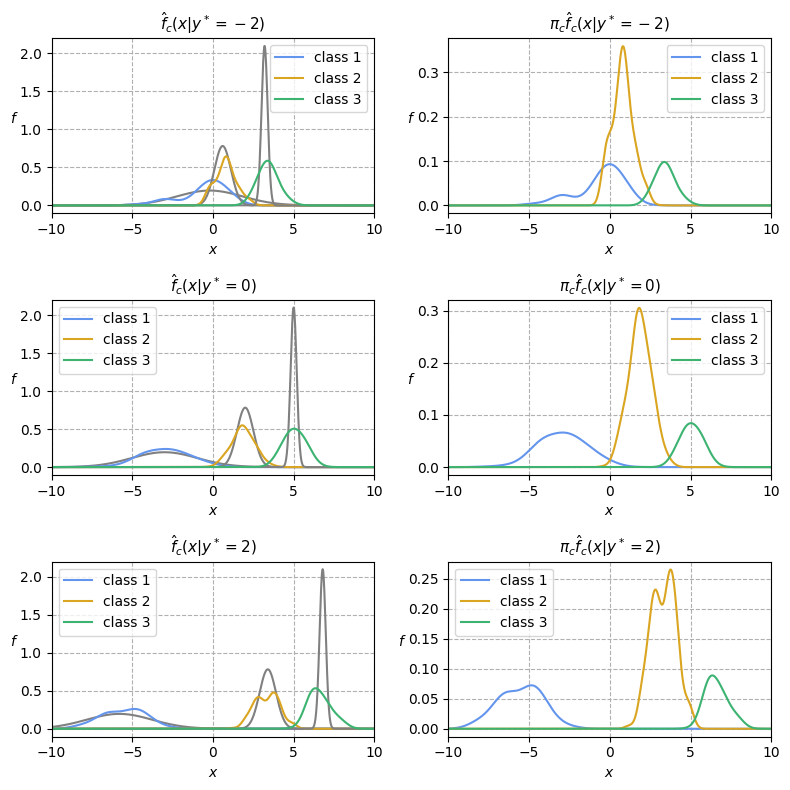

In [35]:
# y*=-2
ckde_classifier_neg = CKDEClassification().fit(x_train[0], y_train[0], y_star_neg, labels_train,
                                           bandwidths_x=bandwidths_x[0], bandwidths_y=bandwidths_y[0])
scores_for_classes_neg = ckde_classifier_neg.pdfs(x_grid)

scores1_neg = scores_for_classes_neg[:, 0]
scores2_neg = scores_for_classes_neg[:, 1]
scores3_neg = scores_for_classes_neg[:, 2]

# y*=0
ckde_classifier_neu = CKDEClassification().fit(x_train[0], y_train[0], y_star_neu, labels_train,
                                           bandwidths_x=bandwidths_x[0], bandwidths_y=bandwidths_y[0])
scores_for_classes_neu = ckde_classifier_neu.pdfs(x_grid)

scores1_neu = scores_for_classes_neu[:, 0]
scores2_neu = scores_for_classes_neu[:, 1]
scores3_neu = scores_for_classes_neu[:, 2]

# y*=2
ckde_classifier_pos = CKDEClassification().fit(x_train[0], y_train[0], y_star_pos, labels_train,
                                           bandwidths_x=bandwidths_x[0], bandwidths_y=bandwidths_y[0])
scores_for_classes_pos = ckde_classifier_pos.pdfs(x_grid)

scores1_pos = scores_for_classes_pos[:, 0]
scores2_pos = scores_for_classes_pos[:, 1]
scores3_pos = scores_for_classes_pos[:, 2]


# Plot
# https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2
fig, axs = plt.subplots(3, 2, figsize=(8, 8), dpi=100)

true_dist1 = norm.pdf(x_grid, loc=-0.2, scale=2.04)
axs[0, 0].plot(x_grid, true_dist1, c="grey")
axs[0, 0].plot(x_grid, scores1_neg, c="cornflowerblue", label="class 1")
true_dist2 = norm.pdf(x_grid, loc=0.6, scale=0.51)
axs[0, 0].plot(x_grid, true_dist2, c="grey")
axs[0, 0].plot(x_grid, scores2_neg, c="goldenrod", label="class 2")
true_dist3 = norm.pdf(x_grid, loc=3.2, scale=0.19)
axs[0, 0].plot(x_grid, true_dist3, c="grey")
axs[0, 0].plot(x_grid, scores3_neg, c="mediumseagreen", label="class 3")
axs[0, 0].set_title("$\hat{f}_c(x|y^*=-2)$", fontsize=11)
axs[0, 0].legend(fontsize=10)
axs[0, 0].set_xlabel("$x$")
axs[0, 0].set_ylabel("$f$", rotation=0)
axs[0, 0].set_xlim(-10, 10)
axs[0, 0].set_ylim(top=2.2)
axs[0, 0].grid(linestyle="--")

axs[0, 1].plot(x_grid, m_train1 / m_train * scores1_neg, c="cornflowerblue", label="class 1")
axs[0, 1].plot(x_grid, m_train2 / m_train * scores2_neg, c="goldenrod", label="class 2")
axs[0, 1].plot(x_grid, m_train3 / m_train * scores3_neg, c="mediumseagreen", label="class 3")
axs[0, 1].set_title("$\\pi_c \\hat{f}_c(x|y^*=-2)$", fontsize=11)
axs[0, 1].legend(fontsize=10)
axs[0, 1].set_xlim(-10, 10)
axs[0, 1].set_xlabel("$x$")
axs[0, 1].set_ylabel("$f$", rotation=0)
axs[0, 1].grid(linestyle="--")



true_dist1 = norm.pdf(x_grid, loc=-3, scale=2.04)
axs[1, 0].plot(x_grid, true_dist1, c="grey")
axs[1, 0].plot(x_grid, scores1_neu, c="cornflowerblue", label="class 1")
true_dist2 = norm.pdf(x_grid, loc=2, scale=0.51)
axs[1, 0].plot(x_grid, true_dist2, c="grey")
axs[1, 0].plot(x_grid, scores2_neu, c="goldenrod", label="class 2")
true_dist3 = norm.pdf(x_grid, loc=5, scale=0.19)
axs[1, 0].plot(x_grid, true_dist3, c="grey")
axs[1, 0].plot(x_grid, scores3_neu, c="mediumseagreen", label="class 3")
axs[1, 0].set_title("$\hat{f}_c(x|y^*=0)$", fontsize=11)
axs[1, 0].legend(fontsize=10)
axs[1, 0].set_xlabel("$x$")
axs[1, 0].set_ylabel("$f$", rotation=0)
axs[1, 0].set_xlim(-10, 10)
axs[1, 0].set_ylim(top=2.2)
axs[1, 0].grid(linestyle="--")

axs[1, 1].plot(x_grid, m_train1 / m_train * scores1_neu, c="cornflowerblue", label="class 1")
axs[1, 1].plot(x_grid, m_train2 / m_train * scores2_neu, c="goldenrod", label="class 2")
axs[1, 1].plot(x_grid, m_train3 / m_train * scores3_neu, c="mediumseagreen", label="class 3")
axs[1, 1].set_title("$\\pi_c \\hat{f}_c(x|y^*=0)$", fontsize=11)
axs[1, 1].legend(fontsize=10)
axs[1, 1].set_xlim(-10, 10)
axs[1, 1].set_xlabel("$x$")
axs[1, 1].set_ylabel("$f$", rotation=0)
axs[1, 1].grid(linestyle="--")



true_dist1 = norm.pdf(x_grid, loc=-5.8, scale=2.04)
axs[2, 0].plot(x_grid, true_dist1, c="grey")
axs[2, 0].plot(x_grid, scores1_pos, c="cornflowerblue", label="class 1")
true_dist2 = norm.pdf(x_grid, loc=3.4, scale=0.51)
axs[2, 0].plot(x_grid, true_dist2, c="grey")
axs[2, 0].plot(x_grid, scores2_pos, c="goldenrod", label="class 2")
true_dist3 = norm.pdf(x_grid, loc=6.8, scale=0.19)
axs[2, 0].plot(x_grid, true_dist3, c="grey")
axs[2, 0].plot(x_grid, scores3_pos, c="mediumseagreen", label="class 3")
axs[2, 0].set_title("$\hat{f}_c(x|y^*=2)$", fontsize=11)
axs[2, 0].legend(fontsize=10)
axs[2, 0].set_xlabel("$x$")
axs[2, 0].set_ylabel("$f$", rotation=0)
axs[2, 0].set_xlim(-10, 10)
axs[2, 0].set_ylim(top=2.2)
axs[2, 0].grid(linestyle="--")

axs[2, 1].plot(x_grid, m_train1 / m_train * scores1_pos, c="cornflowerblue", label="class 1")
axs[2, 1].plot(x_grid, m_train2 / m_train * scores2_pos, c="goldenrod", label="class 2")
axs[2, 1].plot(x_grid, m_train3 / m_train * scores3_pos, c="mediumseagreen", label="class 3")
axs[2, 1].set_title("$\\pi_c \\hat{f}_c(x|y^*=2)$", fontsize=11)
axs[2, 1].legend(fontsize=10)
axs[2, 1].set_xlim(-10, 10)
axs[2, 1].set_xlabel("$x$")
axs[2, 1].set_ylabel("$f$", rotation=0)
axs[2, 1].grid(linestyle="--")


plt.tight_layout()
plt.show()

#### $y^*=-2$

In [36]:
labels_pred = ckde_classifier_neg.predict(x_test_neg)

print(f"Wskaźnik jakości (accuracy): {np.mean(labels_pred == labels_test_neg):.6f}")

Wskaźnik jakości (accuracy): 0.792222


#### $y^*=0$

In [37]:
labels_pred = ckde_classifier_neu.predict(x_test_neu)

print(f"Wskaźnik jakości (accuracy): {np.mean(labels_pred == labels_test_neu):.6f}")

Wskaźnik jakości (accuracy): 0.982222


#### $y^*=2$

In [38]:
labels_pred = ckde_classifier_pos.predict(x_test_pos)

print(f"Wskaźnik jakości (accuracy): {np.mean(labels_pred == labels_test_pos):.6f}")

Wskaźnik jakości (accuracy): 0.994444


In [39]:
### Testowanie na zbiorze testowym (na bazie szarych rozkładów !!! )

#### Testowanie na zbiorze testowym wylosowanym z referencyjnych rozkładów warunkowych $f_c(x \mid y^*=0)$ 



# np.random.seed(0)

# # Test data
# m_test1_0_ = m_test1
# x_test1_0_ = np.random.normal(loc=-3, scale=2.04, size=m_test1_0_)[:,None]
# labels_test1_0_ = np.full(m_test1_0_, 1, dtype=np.int32)

# m_test2_0_ = m_test2
# x_test2_0_ = np.random.normal(loc=2, scale=0.51, size=m_test2_0_)[:,None]
# labels_test2_0_ = np.full(m_test2_0_, 2, dtype=np.int32)

# m_test3_0_ = m_test3
# x_test3_0_ = np.random.normal(loc=5, scale=0.19, size=m_test3_0_)[:,None]
# labels_test3_0_ = np.full(m_test3_0_, 3, dtype=np.int32)

# x_test_0_ = np.concatenate((x_test1_0_, x_test2_0_, x_test3_0_), axis=0)
# labels_test_0_ = np.concatenate((labels_test1_0_, labels_test2_0_, labels_test3_0_))
# m_test_0_ = x_test_0_.shape[0]

# # Classify
# labels_pred = ckde_classifier.predict(x_test_0_)

# print(f"Wskaźnik jakości (dokładność): {np.mean(labels_pred == labels_test_0_):.6f}")